In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
CALIBRATION_FILE = 'calibration_results.json'

def load_intrinsic(fpathid, res_path = CALIBRATION_FILE):
    with open(CALIBRATION_FILE, 'r') as f:
        file_data = json.load(f)
        for entry in file_data['calibration_results']:
            if entry['fpath'] == fpathid:
                ret = entry['ret']
                mtx = np.array(entry['mtx'])
                dist = np.array(entry['dist'])
                rvecs = tuple(np.array(vec) for vec in entry['rvecs'])
                tvecs = tuple(np.array(vec) for vec in entry['tvecs'])
                return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = load_intrinsic("/Users/flap/MasterThesis/source/food-volume-stereo/calibrate_images/ip12_image_small")

In [12]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 
 
criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

CORNER_H = 6
CORNER_W = 9

objp = np.zeros((CORNER_H*CORNER_W, 3), np.float32)
objp[:,:2] = np.mgrid[0:CORNER_W, 0:CORNER_H].T.reshape(-1,2)

L_FPATH = '/Users/flap/MasterThesis/source/food-volume-stereo/calibrate_images/ip12_image_small/IMG_7161.jpeg'
R_FPATH = '/Users/flap/MasterThesis/source/food-volume-stereo/calibrate_images/ip12_image_small/IMG_7163.jpeg'

obj_pts = [objp]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

grayL = cv2.cvtColor(cv2.imread(L_FPATH), cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(grayL, (CORNER_W, CORNER_H), None)   
if ret == True:
    corners2 = cv2.cornerSubPix(grayL, corners, (11,11), (-1,-1), criteria)
    img_ptsL = [corners2]
    

grayR = cv2.cvtColor(cv2.imread(R_FPATH), cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(grayR, (CORNER_W, CORNER_H), None)   
if ret == True:
    corners2 = cv2.cornerSubPix(grayR, corners, (11,11), (-1,-1), criteria)
    img_ptsR = [corners2]



# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = \
    cv2.stereoCalibrate(obj_pts, img_ptsL, img_ptsR, mtx, dist, mtx, dist, grayL.shape[::-1], criteria_stereo, flags)

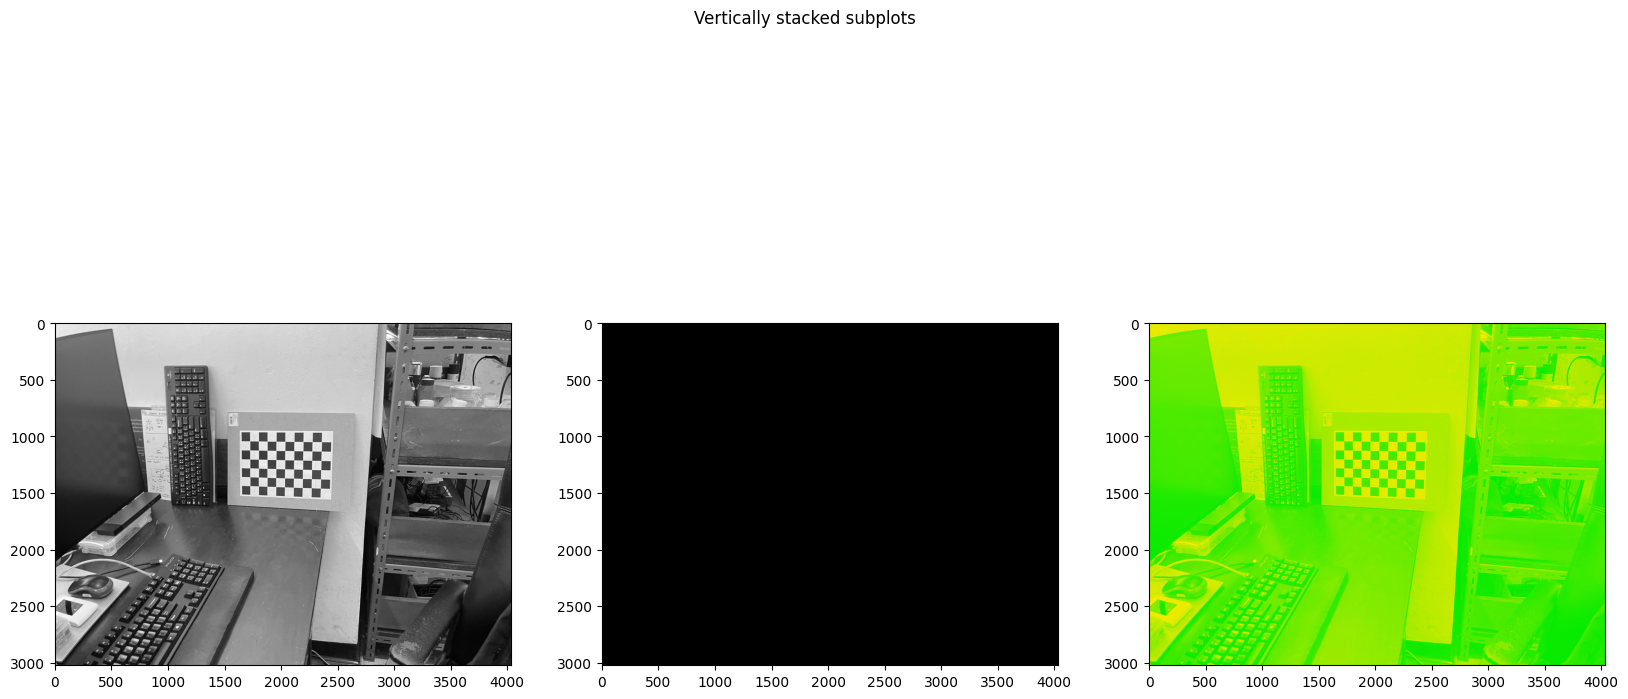

In [9]:
scaled_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
        mtx, dist, grayL.shape[::-1], 0, grayL.shape[::-1]
    )

undistorted_frame = cv2.undistort(
            grayL, mtx, dist, None,
        )

# undistorted_frame2 = cv2.undistort(
#             grayL, mtx, dist, None, scaled_camera_matrix
#         )

undistorted_frame2 = cv2.undistort(
            grayL, mtx, dist, None,scaled_camera_matrix
        )

undistorted_frame3 = cv2.undistort(
            grayL, np.zeros_like(mtx), dist, None, scaled_camera_matrix
)


fig, axs = plt.subplots(1,3, figsize=(20,10))
# fig.set_figheight(20)
# fig.set_figheight(20)
fig.suptitle('Vertically stacked subplots')
axs[0].imshow(undistorted_frame2, cmap='gray')
axs[1].imshow(undistorted_frame3, cmap='gray')
axs[2].imshow(np.stack((undistorted_frame2, undistorted_frame3, np.zeros_like(undistorted_frame)), axis=-1))


In [63]:
scaled_camera_matrix

array([[3.22675317e+03, 0.00000000e+00, 2.08791495e+03],
       [0.00000000e+00, 3.23266675e+03, 1.54532487e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [64]:
mtx

array([[3.02781380e+03, 0.00000000e+00, 2.09199297e+03],
       [0.00000000e+00, 3.02763130e+03, 1.52967520e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [45]:
mtx

array([[3.02781380e+03, 0.00000000e+00, 2.09199297e+03],
       [0.00000000e+00, 3.02763130e+03, 1.52967520e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [65]:
np.abs(mtx / scaled_camera_matrix)

/var/folders/12/qy4gn7r12t5295wlxsddpx600000gp/T/ipykernel_91030/1129336137.py:1: RuntimeWarning: invalid value encountered in divide
  np.abs(mtx / scaled_camera_matrix)


array([[0.93834689,        nan, 1.00195315],
       [       nan, 0.9365739 , 0.98987289],
       [       nan,        nan, 1.        ]])

: 

In [47]:
roi

(85, 72, 3881, 2879)

In [48]:
grayL.shape

(3024, 4032)

In [49]:
print(undistorted_frame.shape, undistorted_frame2.shape)

(3024, 4032) (3024, 4032)


In [50]:
grayL.shape

(3024, 4032)

In [2]:
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
    '''

    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [3]:
L_FPATH = '/Users/flap/MasterThesis/source/food-volume-stereo/calibrate_images/ip12_image_small/IMG_7161.jpeg'
R_FPATH = '/Users/flap/MasterThesis/source/food-volume-stereo/calibrate_images/ip12_image_small/IMG_7163.jpeg'

image_left = cv2.imread(L_FPATH)
image_right = cv2.imread(R_FPATH)
print(image_left.shape)
output_file = "out.ply"

if image_left.shape[0] != image_right.shape[0] or \
        image_left.shape[1] != image_right.shape[1]:
    raise TypeError("Input images must be of the same size")

# downscale images for faster processing
image_left = cv2.pyrDown(cv2.pyrDown(cv2.pyrDown(image_left)))
image_right = cv2.pyrDown(cv2.pyrDown(cv2.pyrDown(image_right)))
print(image_left.shape)

(3024, 4032, 3)
(378, 504, 3)


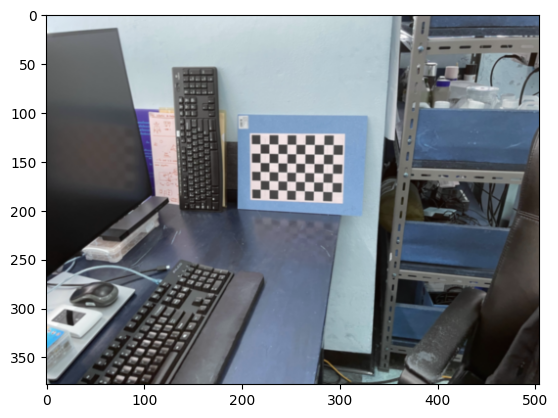

In [4]:
plt.imshow(image_left)

In [18]:
# disparity range is tuned for 'aloe' image pair
win_size = 1
min_disp = 16
max_disp = min_disp * 9
num_disp = max_disp - min_disp   # Needs to be divisible by 16
stereo = cv2.StereoSGBM(minDisparity = min_disp,
    numDisparities = num_disp,
    SADWindowSize = win_size,
    uniquenessRatio = 10,
    speckleWindowSize = 100,
    speckleRange = 32,
    disp12MaxDiff = 1,
    P1 = 8*3*win_size**2,
    P2 = 32*3*win_size**2,
    fullDP = True
)

In [ ]:
disparity_map = stereo.compute(image_left, image_right).astype(np.float32) / 16.0

: 

: 

In [2]:


print("\nComputing the disparity map ...")


# print "\nGenerating the 3D map ..."
h, w = image_left.shape[:2]
focal_length = 0.8*w                          

# Perspective transformation matrix
Q = np.float32([[1, 0, 0, -w/2.0],
                [0,-1, 0,  h/2.0], 
                [0, 0, 0, -focal_length], 
                [0, 0, 1, 0]])

points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
colors = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)
mask_map = disparity_map > disparity_map.min()
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

print("\nCreating the output file ...\n")
create_output(output_points, output_colors, output_file)

: 

: 